A Knowledge Graph is a set of data points connected by relations that describe a domain, for instance, a business, an organization, or a field of study. It is a powerful way of representing data because Knowledge Graphs can be built automatically and then explored to reveal new insights about the domain.

In [11]:
!pip install spacy

In [23]:
!spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [120]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [137]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4317, 1)

In [122]:
candidate_sentences['sentence'].sample(5)

2330                                                                the sequels halloween h20:
3037                                                this version of the film runs 124 minutes.
681     her gyrating and moving pelvis was censored, one of the earliest films to be censored.
3182                                                                some would consider 1977's
1910                                      it stars brad pitt, morgan freeman, gwyneth paltrow,
Name: sentence, dtype: object

In [123]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


## Entity Pairs Extraction
To build a knowledge graph, the most important things are the nodes and the edges between them.

In [124]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Chunk 1

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that last word itself, respectively. Prefix and modifier will have the text associated with the subject or the object.

Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the ticket is a punctuation mark or not. If yes, we will ignore it and move on to the next token. If the pass is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a comment with a new meaning (example – “Football Stadium,” “animal lover”).
When we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same with the modifier words, such as “nice shirt,” “big house,” etc.

Chunk 3

Here, if the token is the subject, it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

Chunk 4

Here, if the token is the object, it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.



In [125]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [149]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"].sample(250)):
  entity_pairs.append(get_entities(i))




  0%|          | 0/250 [00:00<?, ?it/s]


  3%|▎         | 7/250 [00:00<00:03, 65.85it/s]


  8%|▊         | 19/250 [00:00<00:02, 93.42it/s]


 12%|█▏        | 30/250 [00:00<00:02, 97.53it/s]


 17%|█▋        | 42/250 [00:00<00:02, 103.44it/s]


 21%|██        | 53/250 [00:00<00:01, 105.33it/s]


 26%|██▌       | 64/250 [00:00<00:01, 101.25it/s]


 30%|███       | 76/250 [00:00<00:01, 107.00it/s]


 35%|███▍      | 87/250 [00:00<00:01, 105.90it/s]


 39%|███▉      | 98/250 [00:00<00:01, 106.28it/s]


 44%|████▎     | 109/250 [00:01<00:01, 104.64it/s]


 48%|████▊     | 120/250 [00:01<00:01, 104.93it/s]


 53%|█████▎    | 132/250 [00:01<00:01, 107.79it/s]


 57%|█████▋    | 143/250 [00:01<00:01, 106.68it/s]


 62%|██████▏   | 155/250 [00:01<00:00, 108.19it/s]


 66%|██████▋   | 166/250 [00:01<00:00, 107.76it/s]


 71%|███████   | 177/250 [00:01<00:00, 106.37it/s]


 75%|███████▌  | 188/250 [00:01<00:00, 106.54it/s]


 80%|███████▉  | 199/250 [00:01<00:00, 107.30it/s]


 84%|████████▍

The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences.

In [150]:
entity_pairs[10:20]

[['bonnie', 'new  hollywood'],
 ['director', 'last  time'],
 ['most  scripts', 'blocking'],
 ['film', 'may'],
 ['result', 'technicians'],
 ['it', 'indian  domestic'],
 ['they', 'also  period'],
 ['xrco awards', 'rated critics organization'],
 ['warden', 'former president richard nixon'],
 ['cameron', 'share']]

There are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns. For the time being, let’s leave it as it is and move on to the relation extraction part.

This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

**Relation / Predicate Extraction**

In [151]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1    

  span = doc[matches[k][1]:matches[k][2]] 


  return(span.text)

In [152]:
get_relation("John completed the task")

'completed'

In [153]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'].sample(250))]




  0%|          | 0/250 [00:00<?, ?it/s]


  3%|▎         | 8/250 [00:00<00:03, 75.42it/s]


  8%|▊         | 19/250 [00:00<00:02, 92.18it/s]


 12%|█▏        | 30/250 [00:00<00:02, 97.47it/s]


 16%|█▌        | 40/250 [00:00<00:02, 93.48it/s]


 20%|██        | 50/250 [00:00<00:02, 94.41it/s]


 24%|██▍       | 60/250 [00:00<00:01, 95.58it/s]


 28%|██▊       | 70/250 [00:00<00:01, 92.01it/s]


 33%|███▎      | 82/250 [00:00<00:01, 99.18it/s]


 37%|███▋      | 92/250 [00:00<00:01, 97.74it/s]


 41%|████      | 102/250 [00:01<00:01, 92.45it/s]


 45%|████▍     | 112/250 [00:01<00:01, 90.70it/s]


 49%|████▉     | 122/250 [00:01<00:01, 87.59it/s]


 53%|█████▎    | 133/250 [00:01<00:01, 92.81it/s]


 57%|█████▋    | 143/250 [00:01<00:01, 94.00it/s]


 61%|██████    | 153/250 [00:01<00:01, 91.24it/s]


 65%|██████▌   | 163/250 [00:01<00:01, 84.15it/s]


 69%|██████▉   | 172/250 [00:01<00:00, 78.93it/s]


 72%|███████▏  | 181/250 [00:02<00:00, 76.47it/s]


 76%|███████▌  | 190/250 [00:

In [154]:
pd.Series(relations).value_counts()[:50]

was                       21
is                        21
include                    7
are                        4
were                       4
's                         4
released                   4
made                       3
produced by                3
discontinued from 15th     3
released on                3
produced                   3
became                     2
ended                      2
referred to                2
play                       2
written by                 2
made in                    2
designed                   2
ran                        2
have                       2
included                   2
showcased                  2
came                       2
used                       2
adds to                    2
become                     2
began in                   2
performed by               2
stops                      1
written by different       1
was expensive              1
combined in                1
had warm                   1
introduced    

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

**Build a Knowledge Graph**

In [155]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

In [156]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

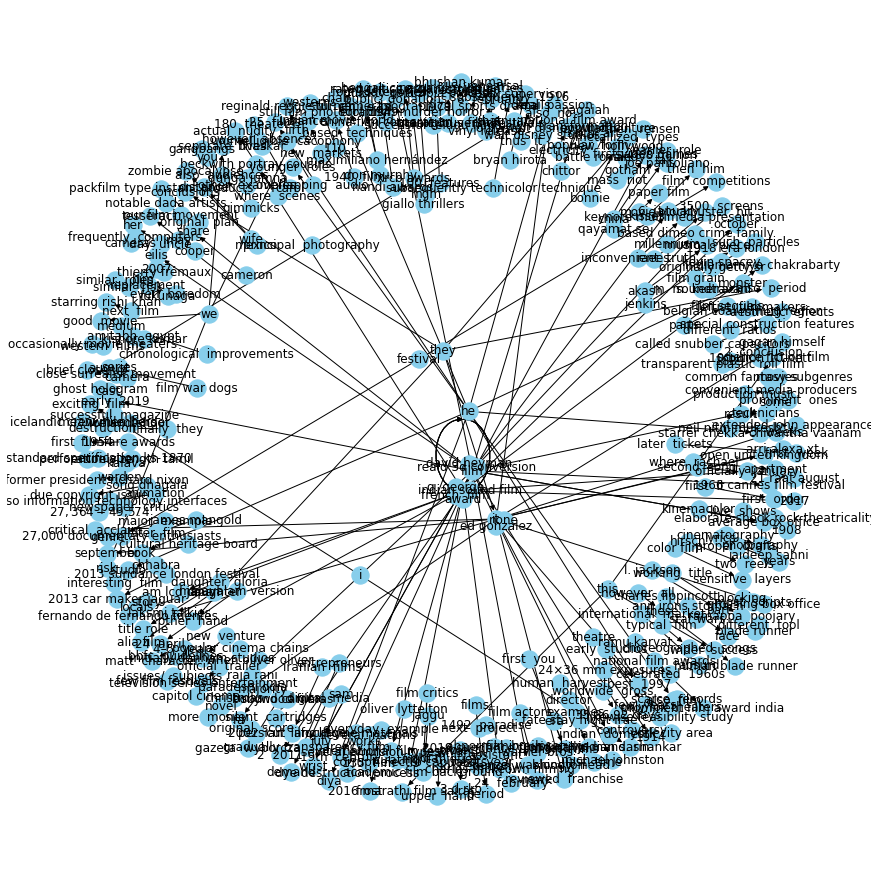

In [157]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph.

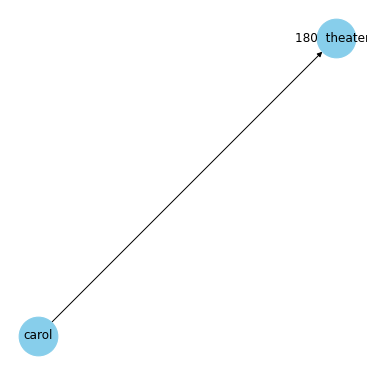

In [162]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

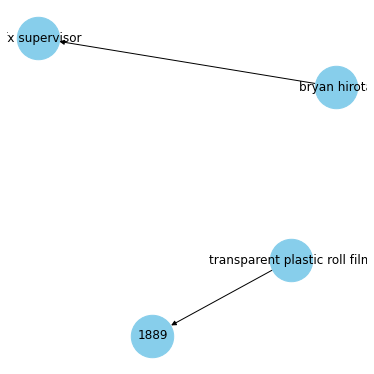

In [165]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1800, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

we restricted ourselves to use sentences with exactly 2 entities. Even then we were able to build quite informative knowledge graphs.